In [13]:
# ---- Cell 1: Imports and RNG helper ----

import math
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt


def make_rng(seed: int) -> np.random.Generator:
    """Create a NumPy random number generator.

    Args:
        seed (int): Integer random seed.

    Returns:
        np.random.Generator: NumPy random number generator instance.
    """
    return np.random.default_rng(seed)


In [14]:
# ---- Cell 2: 1D Ising utilities ----

def ising1d_initial_state(num_spins: int, rng: np.random.Generator) -> np.ndarray:
    """Initialise a 1D Ising chain with random spins.

    Args:
        num_spins (int): Number of spins in the chain.
        rng (np.random.Generator): Random number generator.

    Returns:
        np.ndarray: Array of spins with values +1 or -1.
    """
    spins = rng.choice([-1, 1], size=num_spins)
    return spins.astype(np.int8)


def ising1d_energy(spins: np.ndarray, coupling: float = 1.0) -> float:
    """Compute the total energy of a 1D Ising chain with periodic boundaries.

    Args:
        spins (np.ndarray): One dimensional array of spins.
        coupling (float): Coupling constant J.

    Returns:
        float: Total energy of the configuration.
    """
    interaction = spins * np.roll(spins, -1)
    energy = -coupling * np.sum(interaction)
    return float(energy)


def metropolis_sweep_1d(
    spins: np.ndarray,
    beta: float,
    rng: np.random.Generator,
    coupling: float = 1.0,
) -> None:
    """Perform a single Metropolis sweep over a 1D chain.

    Spins are updated in random order.

    Args:
        spins (np.ndarray): One dimensional array of spins to be updated in place.
        beta (float): Inverse temperature 1 / T.
        rng (np.random.Generator): Random number generator.
        coupling (float): Coupling constant J.

    Returns:
        None: The spins array is updated in place.
    """
    num_spins = spins.size
    for _ in range(num_spins):
        i = rng.integers(0, num_spins)
        left = spins[(i - 1) % num_spins]
        right = spins[(i + 1) % num_spins]
        delta_e = 2.0 * coupling * spins[i] * (left + right)
        if delta_e <= 0.0:
            spins[i] *= -1
        else:
            if rng.random() < math.exp(-beta * delta_e):
                spins[i] *= -1


def ising1d_exact_energy_per_spin(beta: float, coupling: float = 1.0) -> float:
    """Compute analytic energy per spin for the infinite 1D Ising chain.

    Uses the thermodynamic limit result:

        e_exact / J = -tanh(beta * J)

    Args:
        beta (float): Inverse temperature 1 / T.
        coupling (float): Coupling constant J.

    Returns:
        float: Analytic energy per spin in units of J.
    """
    return -coupling * math.tanh(beta * coupling)


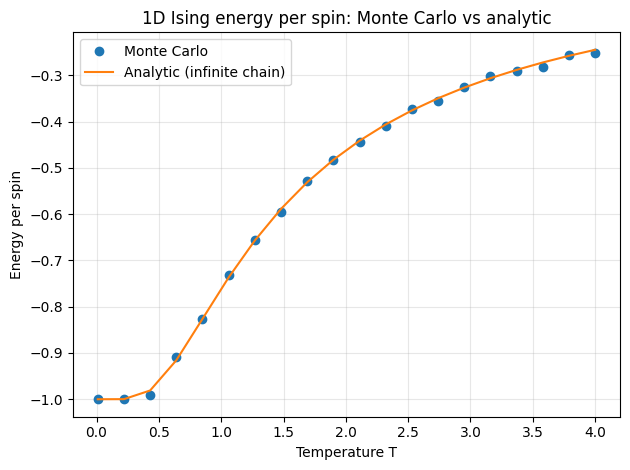

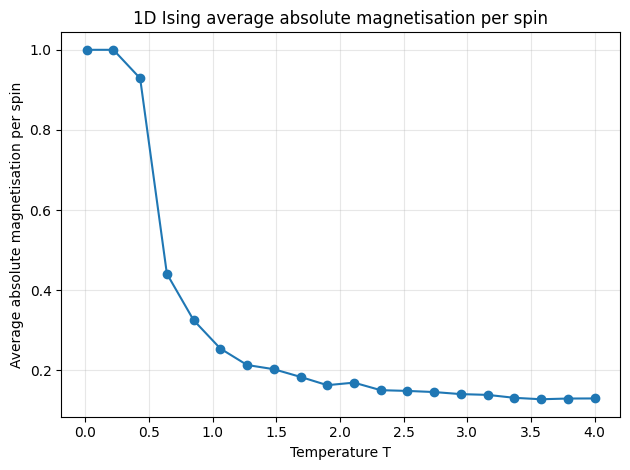

In [15]:
# ---- Cell 3: 1D Ising validation run  ----

def run_ising1d_validation() -> None:
    """Run 1D Ising Monte Carlo and compare with analytic energy.

    The run:
        - Temperatures from T = 0.01 to T = 4.0 (20 points).
        - 64 spins, Metropolis sampling.
        - Estimates energy per spin and absolute magnetisation per spin.
        - Compares energy with analytic result for the infinite chain.
        - Shows plots in the notebook.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=123)

    num_spins = 64
    coupling = 1.0

    temperatures = np.linspace(0.01, 4.0, 20)
    beta_values = 1.0 / temperatures

    num_burn_in_sweeps = 3000
    num_measure_sweeps = 7000
    sample_interval = 10

    energy_mc = []
    mag_abs_mc = []
    energy_exact = []

    spins = ising1d_initial_state(num_spins=num_spins, rng=rng)

    for beta, temp in zip(beta_values, temperatures):
        for _ in range(num_burn_in_sweeps):
            metropolis_sweep_1d(spins, beta=beta, rng=rng, coupling=coupling)

        energies = []
        mags_abs = []

        for sweep in range(num_measure_sweeps):
            metropolis_sweep_1d(spins, beta=beta, rng=rng, coupling=coupling)
            if sweep % sample_interval == 0:
                e = ising1d_energy(spins, coupling=coupling) / num_spins
                m_abs = abs(np.sum(spins)) / num_spins
                energies.append(e)
                mags_abs.append(m_abs)

        energy_mc.append(float(np.mean(energies)))
        mag_abs_mc.append(float(np.mean(mags_abs)))
        energy_exact.append(ising1d_exact_energy_per_spin(beta, coupling=coupling))

    energy_mc = np.array(energy_mc)
    mag_abs_mc = np.array(mag_abs_mc)
    energy_exact = np.array(energy_exact)

    plt.figure()
    plt.plot(temperatures, energy_mc, "o", label="Monte Carlo")
    plt.plot(temperatures, energy_exact, "-", label="Analytic (infinite chain)")
    plt.xlabel("Temperature T")
    plt.ylabel("Energy per spin")
    plt.title("1D Ising energy per spin: Monte Carlo vs analytic")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, mag_abs_mc, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Average absolute magnetisation per spin")
    plt.title("1D Ising average absolute magnetisation per spin")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Run 1D validation
run_ising1d_validation()


In [16]:
# ---- Cell 4: 2D Ising utilities ----

def ising2d_initial_state(lattice_size: int, rng: np.random.Generator) -> np.ndarray:
    """Initialise a 2D Ising lattice with random spins.

    Args:
        lattice_size (int): Linear size L of the lattice.
        rng (np.random.Generator): Random number generator.

    Returns:
        np.ndarray: Two dimensional array of spins with values +1 or -1.
    """
    spins = rng.choice([-1, 1], size=(lattice_size, lattice_size))
    return spins.astype(np.int8)


def ising2d_energy(spins: np.ndarray, coupling: float = 1.0) -> float:
    """Compute the total energy of a 2D Ising model with periodic boundaries.

    Args:
        spins (np.ndarray): Two dimensional array of spins.
        coupling (float): Coupling constant J.

    Returns:
        float: Total energy of the configuration.
    """
    right = np.roll(spins, shift=-1, axis=1)
    down = np.roll(spins, shift=-1, axis=0)
    interaction = spins * (right + down)
    energy = -coupling * np.sum(interaction)
    return float(energy)


def metropolis_sweep_2d(
    spins: np.ndarray,
    beta: float,
    rng: np.random.Generator,
    coupling: float = 1.0,
) -> None:
    """Perform a Metropolis sweep over all spins in a 2D lattice.

    Spins are updated in random order.

    Args:
        spins (np.ndarray): Two dimensional array of spins to be updated in place.
        beta (float): Inverse temperature 1 / T.
        rng (np.random.Generator): Random number generator.
        coupling (float): Coupling constant J.

    Returns:
        None: The spins array is updated in place.
    """
    l = spins.shape[0]
    num_sites = l * l
    for _ in range(num_sites):
        i = rng.integers(0, l)
        j = rng.integers(0, l)
        up = spins[(i - 1) % l, j]
        down = spins[(i + 1) % l, j]
        left = spins[i, (j - 1) % l]
        right = spins[i, (j + 1) % l]
        neighbour_sum = up + down + left + right
        delta_e = 2.0 * coupling * spins[i, j] * neighbour_sum
        if delta_e <= 0.0:
            spins[i, j] *= -1
        else:
            if rng.random() < math.exp(-beta * delta_e):
                spins[i, j] *= -1


def measure_observables_2d(spins: np.ndarray, beta: float) -> Tuple[float, float]:
    """Measure energy per spin and magnetisation per spin for a 2D configuration.

    Args:
        spins (np.ndarray): Two dimensional array of spins.
        beta (float): Inverse temperature (not directly used here).

    Returns:
        Tuple[float, float]: Energy per spin and magnetisation per spin.
    """
    energy = ising2d_energy(spins)
    num_sites = spins.size
    energy_per_spin = energy / num_sites
    magnetisation_per_spin = float(np.sum(spins)) / num_sites
    return energy_per_spin, magnetisation_per_spin


T = 0.010  <|M|> = 0.5000  C_v = 0.0000  chi = 0.0000
T = 0.453  <|M|> = 0.1583  C_v = 0.0189  chi = 17.6769
T = 0.897  <|M|> = 0.9998  C_v = 0.0085  chi = 0.0005
T = 1.340  <|M|> = 0.9932  C_v = 0.1201  chi = 0.0142
T = 1.783  <|M|> = 0.9598  C_v = 0.4547  chi = 0.0966
T = 2.227  <|M|> = 0.7612  C_v = 1.2211  chi = 3.0962
T = 2.670  <|M|> = 0.2725  C_v = 0.5869  chi = 3.0593
T = 3.113  <|M|> = 0.1529  C_v = 0.3606  chi = 0.9903
T = 3.557  <|M|> = 0.1240  C_v = 0.2202  chi = 0.5916
T = 4.000  <|M|> = 0.1068  C_v = 0.1795  chi = 0.3726


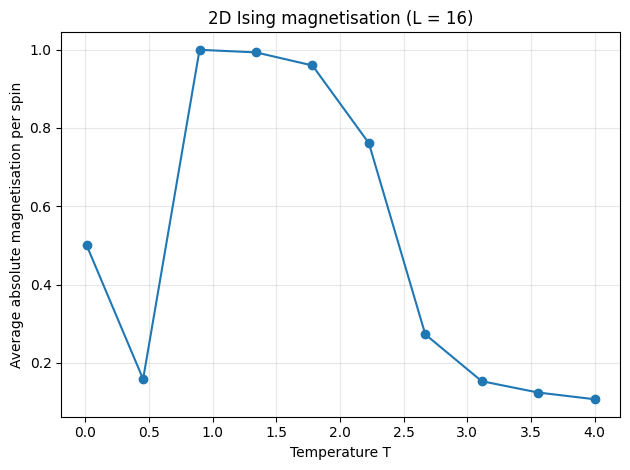

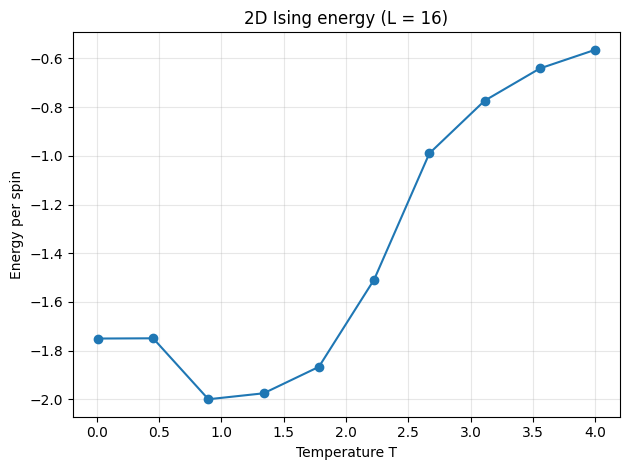

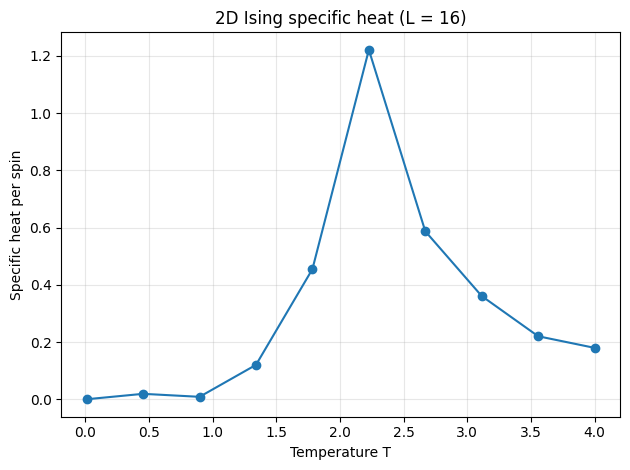

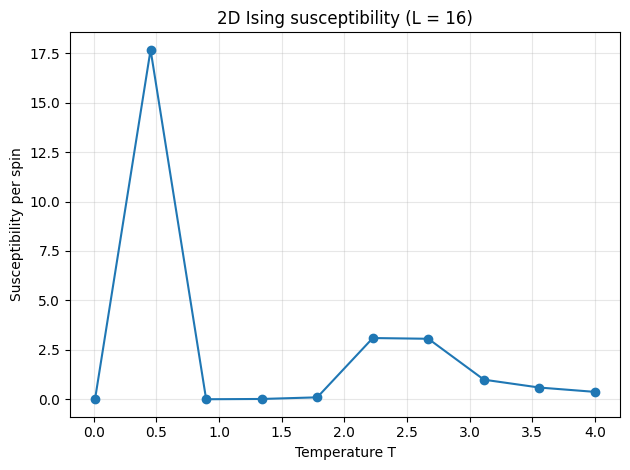

In [17]:
# ---- Cell 5: 2D temperature sweep (L = 16, T = 0.01..4.0) ----

def run_ising2d_temperature_sweep() -> None:
    """Run a 2D Ising temperature sweep for a single lattice size.

    The run:
        - L = 16.
        - Temperatures between 0.01 and 4.0 (10 points).
        - For each T: burn-in then measurement sweeps.
        - Computes energy, absolute magnetisation, specific heat and
          susceptibility as functions of temperature.
        - Prints summary lines and shows four plots.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=321)

    lattice_size = 16
    t_min = 0.01
    t_max = 4.0
    num_temps = 10

    num_burn_in_sweeps = 1000
    num_measure_sweeps = 5000
    sample_interval = 10

    temperatures = np.linspace(t_min, t_max, num_temps)
    beta_values = 1.0 / temperatures

    energies_mean = []
    mags_abs_mean = []
    cvs = []
    chis = []

    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)
    num_sites = spins.size

    for beta, temp in zip(beta_values, temperatures):
        for _ in range(num_burn_in_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)

        e_samples = []
        m_samples = []

        for sweep in range(num_measure_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)
            if sweep % sample_interval == 0:
                e, m = measure_observables_2d(spins, beta)
                e_samples.append(e)
                m_samples.append(m)

        e_arr = np.array(e_samples)
        m_arr = np.array(m_samples)
        m_abs_arr = np.abs(m_arr)

        e_mean = float(np.mean(e_arr))
        m_abs_mean = float(np.mean(m_abs_arr))

        cv = (beta ** 2) * num_sites * float(np.var(e_arr, ddof=1))
        chi = beta * num_sites * (
            float(np.mean(m_arr ** 2)) - float(np.mean(m_abs_arr) ** 2)
        )

        energies_mean.append(e_mean)
        mags_abs_mean.append(m_abs_mean)
        cvs.append(cv)
        chis.append(chi)

        print(
            f"T = {temp:.3f}  <|M|> = {m_abs_mean:.4f}  "
            f"C_v = {cv:.4f}  chi = {chi:.4f}"
        )

    energies_mean = np.array(energies_mean)
    mags_abs_mean = np.array(mags_abs_mean)
    cvs = np.array(cvs)
    chis = np.array(chis)

    plt.figure()
    plt.plot(temperatures, mags_abs_mean, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Average absolute magnetisation per spin")
    plt.title("2D Ising magnetisation (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, energies_mean, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Energy per spin")
    plt.title("2D Ising energy (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, cvs, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Specific heat per spin")
    plt.title("2D Ising specific heat (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, chis, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Susceptibility per spin")
    plt.title("2D Ising susceptibility (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Run the temperature sweep
run_ising2d_temperature_sweep()


In [18]:
# ---- Cell 6: finite size scaling helpers ----

@dataclass
class SimulationResult:
    """Container for simulation results for a given lattice size and temperature.

    Attributes:
        temperature (float): Simulation temperature T.
        energy_mean (float): Mean energy per spin.
        energy_var (float): Variance of the energy per spin.
        mag_mean (float): Mean magnetisation per spin.
        mag_abs_mean (float): Mean absolute magnetisation per spin.
        mag2_mean (float): Mean of the squared magnetisation per spin.
    """

    temperature: float
    energy_mean: float
    energy_var: float
    mag_mean: float
    mag_abs_mean: float
    mag2_mean: float


def run_ising2d_simulation(
    lattice_size: int,
    temperature: float,
    num_sweeps: int,
    burn_in_sweeps: int,
    sample_interval: int,
    rng: np.random.Generator,
) -> SimulationResult:
    """Run a 2D Ising simulation and measure observables.

    Args:
        lattice_size (int): Linear lattice size L.
        temperature (float): Temperature T.
        num_sweeps (int): Number of total sweeps after burn-in.
        burn_in_sweeps (int): Number of sweeps for burn-in.
        sample_interval (int): Interval between measurements in sweeps.
        rng (np.random.Generator): Random number generator.

    Returns:
        SimulationResult: Object containing energy and magnetisation statistics.
    """
    beta = 1.0 / temperature
    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)
    num_sites = lattice_size * lattice_size

    for _ in range(burn_in_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    energy_samples = []
    mag_samples = []

    for sweep in range(num_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            e, m = measure_observables_2d(spins, beta)
            energy_samples.append(e)
            mag_samples.append(m)

    e_arr = np.array(energy_samples)
    m_arr = np.array(mag_samples)
    m_abs_arr = np.abs(m_arr)

    energy_mean = float(np.mean(e_arr))
    energy_var = float(np.var(e_arr, ddof=1))
    mag_mean = float(np.mean(m_arr))
    mag_abs_mean = float(np.mean(m_abs_arr))
    mag2_mean = float(np.mean(m_arr ** 2))

    return SimulationResult(
        temperature=temperature,
        energy_mean=energy_mean,
        energy_var=energy_var,
        mag_mean=mag_mean,
        mag_abs_mean=mag_abs_mean,
        mag2_mean=mag2_mean,
    )


Starting finite size study for L = 16
L = 16, T = 1.800  <|M|> = 0.9572  C_v = 0.4350  chi = 0.1072
L = 16, T = 1.852  <|M|> = 0.9493  C_v = 0.4836  chi = 0.1716
L = 16, T = 1.904  <|M|> = 0.9390  C_v = 0.5438  chi = 0.1720
L = 16, T = 1.957  <|M|> = 0.9229  C_v = 0.6634  chi = 0.3979
L = 16, T = 2.009  <|M|> = 0.9098  C_v = 0.6973  chi = 0.4279
L = 16, T = 2.061  <|M|> = 0.8806  C_v = 0.9471  chi = 0.9920
L = 16, T = 2.113  <|M|> = 0.8578  C_v = 1.0962  chi = 1.2759
L = 16, T = 2.165  <|M|> = 0.8334  C_v = 1.0601  chi = 1.3283
L = 16, T = 2.217  <|M|> = 0.7879  C_v = 1.3014  chi = 2.2560
L = 16, T = 2.270  <|M|> = 0.7148  C_v = 1.5909  chi = 4.1212
L = 16, T = 2.322  <|M|> = 0.6410  C_v = 1.4366  chi = 5.0047
L = 16, T = 2.374  <|M|> = 0.5798  C_v = 1.4226  chi = 5.2755
L = 16, T = 2.426  <|M|> = 0.5073  C_v = 1.3084  chi = 5.6637
L = 16, T = 2.478  <|M|> = 0.4205  C_v = 1.1402  chi = 5.6205
L = 16, T = 2.530  <|M|> = 0.3728  C_v = 1.0261  chi = 4.6284
L = 16, T = 2.583  <|M|> = 0.322

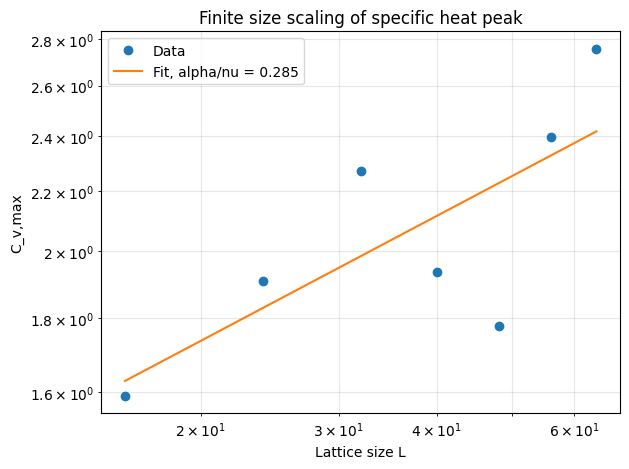

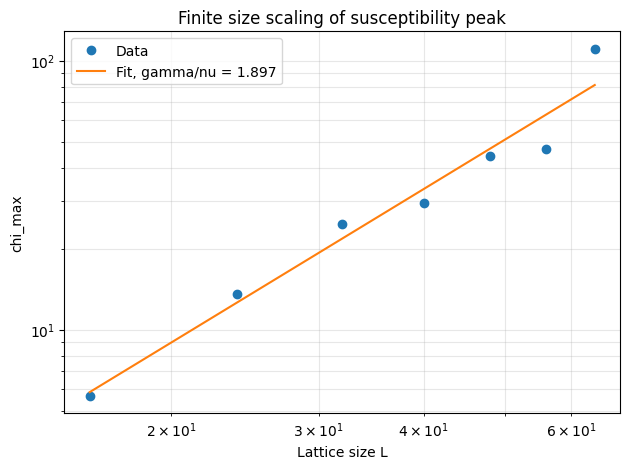

In [19]:
# ---- Cell 7: finite size scaling run (L = 16..64, T = 1.8..3.0) ----

def run_finite_size_scaling() -> None:
    """Perform finite size scaling study for the 2D Ising model.

    The run:
        - L = 16, 24, 32, 40, 48, 56, 64.
        - Temperatures between 1.8 and 3.0 (24 points).
        - For each (L, T) uses Metropolis sampling.
        - Computes specific heat and susceptibility.
        - Extracts peak values and fits power laws to estimate exponent ratios.
        - Prints exponent estimates and shows scaling plots.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=987)

    lattice_sizes = [16, 24, 32, 40, 48, 56, 64]
    t_min = 1.8
    t_max = 3.0
    num_temps = 24

    num_sweeps = 12000
    burn_in_sweeps = 4000
    sample_interval = 10

    temperatures = np.linspace(t_min, t_max, num_temps)

    cv_max_list = []
    chi_max_list = []
    cv_max_t_list = []
    chi_max_t_list = []

    for l in lattice_sizes:
        num_sites = l * l
        cvs_l = []
        chis_l = []

        print(f"Starting finite size study for L = {l}")
        for temp in temperatures:
            beta = 1.0 / temp
            result = run_ising2d_simulation(
                lattice_size=l,
                temperature=temp,
                num_sweeps=num_sweeps,
                burn_in_sweeps=burn_in_sweeps,
                sample_interval=sample_interval,
                rng=rng,
            )
            cv = beta ** 2 * num_sites * result.energy_var
            chi = beta * num_sites * (result.mag2_mean - result.mag_abs_mean ** 2)

            cvs_l.append(cv)
            chis_l.append(chi)

            print(
                f"L = {l:2d}, T = {temp:.3f}  "
                f"<|M|> = {result.mag_abs_mean:.4f}  "
                f"C_v = {cv:.4f}  chi = {chi:.4f}"
            )

        cvs_l = np.array(cvs_l)
        chis_l = np.array(chis_l)

        idx_cv = int(np.argmax(cvs_l))
        idx_chi = int(np.argmax(chis_l))

        cv_max = float(cvs_l[idx_cv])
        t_cv_max = float(temperatures[idx_cv])

        chi_max = float(chis_l[idx_chi])
        t_chi_max = float(temperatures[idx_chi])

        cv_max_list.append(cv_max)
        chi_max_list.append(chi_max)
        cv_max_t_list.append(t_cv_max)
        chi_max_t_list.append(t_chi_max)

        print(
            f"Completed sweep for L = {l}, "
            f"max C_v = {cv_max:.3f} at T = {t_cv_max:.3f}, "
            f"max chi = {chi_max:.3f} at T = {t_chi_max:.3f}"
        )

    lattice_sizes_arr = np.array(lattice_sizes, dtype=float)
    cv_max_arr = np.array(cv_max_list)
    chi_max_arr = np.array(chi_max_list)

    log_L = np.log(lattice_sizes_arr)
    log_cv = np.log(cv_max_arr)
    log_chi = np.log(chi_max_arr)

    alpha_over_nu, log_a_cv = np.polyfit(log_L, log_cv, 1)
    gamma_over_nu, log_a_chi = np.polyfit(log_L, log_chi, 1)

    print("Finite-size scaling estimates:")
    print(f"  alpha / nu from C_v peaks  ~= {alpha_over_nu:.3f}")
    print(f"  gamma / nu from chi peaks ~= {gamma_over_nu:.3f}")

    plt.figure()
    plt.loglog(lattice_sizes_arr, cv_max_arr, "o", label="Data")
    plt.loglog(
        lattice_sizes_arr,
        np.exp(log_a_cv) * lattice_sizes_arr ** alpha_over_nu,
        "-",
        label=f"Fit, alpha/nu = {alpha_over_nu:.3f}",
    )
    plt.xlabel("Lattice size L")
    plt.ylabel("C_v,max")
    plt.title("Finite size scaling of specific heat peak")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.loglog(lattice_sizes_arr, chi_max_arr, "o", label="Data")
    plt.loglog(
        lattice_sizes_arr,
        np.exp(log_a_chi) * lattice_sizes_arr ** gamma_over_nu,
        "-",
        label=f"Fit, gamma/nu = {gamma_over_nu:.3f}",
    )
    plt.xlabel("Lattice size L")
    plt.ylabel("chi_max")
    plt.title("Finite size scaling of susceptibility peak")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()



run_finite_size_scaling()


In [20]:
# ---- Cell 8: correlation length helpers ----

def estimate_correlation_function(
    spins_samples: List[np.ndarray], max_distance: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Estimate the spin correlation function C(r) from saved configurations.

    Args:
        spins_samples (List[np.ndarray]): List of 2D spin configurations.
        max_distance (int): Maximum spin separation r to consider.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Distances r and correlation values C(r).
    """
    l = spins_samples[0].shape[0]
    num_samples = len(spins_samples)

    r_values = np.arange(0, max_distance + 1, dtype=int)
    c_accum = np.zeros_like(r_values, dtype=float)

    for spins in spins_samples:
        m = np.mean(spins)
        for idx, r in enumerate(r_values):
            prod = spins * np.roll(spins, shift=-r, axis=1)
            c_r = np.mean(prod) - m * m
            c_accum[idx] += c_r

    c_r_values = c_accum / num_samples
    return r_values, c_r_values


Estimated correlation length at T = 2.300: xi = 2.339 lattice spacings


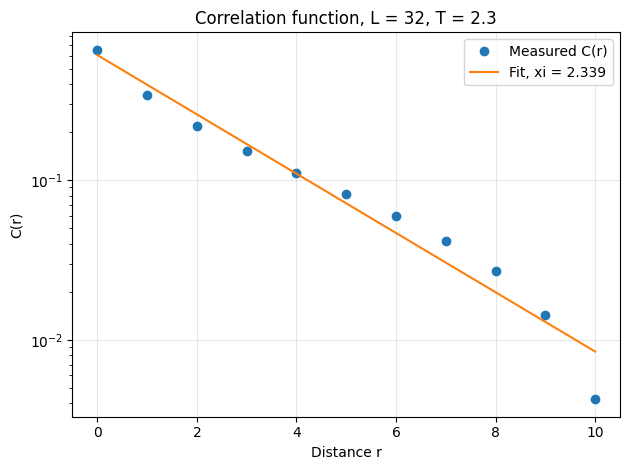

In [21]:
# ---- Cell 9: correlation length run (L = 32, T = 2.3) ----

def run_correlation_length() -> None:
    """Estimate the correlation length of the 2D Ising model near T_c.

    The run:
        - L = 32 at T = 2.3.
        - Burn-in then measurement sweeps, sampling configurations.
        - Computes C(r) and fits an exponential decay to extract xi.
        - Prints xi and shows C(r) plot with fit.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=456)

    lattice_size = 32
    temperature = 2.3
    beta = 1.0 / temperature

    num_burn_in_sweeps = 10000
    num_measure_sweeps = 50000
    sample_interval = 50
    max_distance = 10

    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)

    for _ in range(num_burn_in_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    samples = []
    for sweep in range(num_measure_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            samples.append(spins.copy())

    r_values, c_r_values = estimate_correlation_function(samples, max_distance)

    fit_mask = (r_values >= 1) & (r_values <= max_distance)
    r_fit = r_values[fit_mask].astype(float)
    c_fit = c_r_values[fit_mask]

    positive_mask = c_fit > 0.0
    r_fit = r_fit[positive_mask]
    c_fit = c_fit[positive_mask]

    log_c = np.log(c_fit)
    slope, log_c0 = np.polyfit(r_fit, log_c, 1)
    xi = -1.0 / slope

    print(
        f"Estimated correlation length at T = {temperature:.3f}: "
        f"xi = {xi:.3f} lattice spacings"
    )

    plt.figure()
    plt.semilogy(r_values, c_r_values, "o", label="Measured C(r)")
    c_fit_curve = np.exp(log_c0 + slope * r_values)
    plt.semilogy(r_values, c_fit_curve, "-", label=f"Fit, xi = {xi:.3f}")
    plt.xlabel("Distance r")
    plt.ylabel("C(r)")
    plt.title(f"Correlation function, L = {lattice_size}, T = {temperature}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



run_correlation_length()


In [22]:
# ---- Cell 10: parallel tempering and statistics helpers ----

@dataclass
class PTConfig:
    """Configuration parameters for a parallel tempering run.

    Attributes:
        lattice_size (int): Linear lattice size L.
        num_replicas (int): Number of temperature replicas.
        temperature_min (float): Minimum temperature in the PT ladder.
        temperature_max (float): Maximum temperature in the PT ladder.
        num_sweeps (int): Total number of sweeps in the PT run.
        burn_in_sweeps (int): Number of sweeps used for burn-in.
        sample_interval (int): Interval in sweeps between recorded samples.
        swap_interval (int): Interval in sweeps between attempted replica swaps.
        random_seed (int): Integer random seed for reproducibility.
    """

    lattice_size: int
    num_replicas: int
    temperature_min: float
    temperature_max: float
    num_sweeps: int
    burn_in_sweeps: int
    sample_interval: int
    swap_interval: int
    random_seed: int


def run_parallel_tempering(config: PTConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Run parallel tempering for the 2D Ising model.

    Args:
        config (PTConfig): Parallel tempering configuration parameters.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Temperatures and energy samples per replica.
    """
    rng = make_rng(config.random_seed)
    l = config.lattice_size
    num_sites = l * l

    temperatures = np.linspace(
        config.temperature_min, config.temperature_max, config.num_replicas
    )
    betas = 1.0 / temperatures

    spins_list: List[np.ndarray] = []
    energies = np.zeros(config.num_replicas, dtype=float)

    for _ in range(config.num_replicas):
        spins = ising2d_initial_state(lattice_size=l, rng=rng)
        spins_list.append(spins)

    for i in range(config.num_replicas):
        energies[i] = ising2d_energy(spins_list[i])

    num_sweeps_total = config.num_sweeps
    burn_in = config.burn_in_sweeps
    sample_interval = config.sample_interval
    swap_interval = config.swap_interval

    energy_samples_list: List[np.ndarray] = []

    swap_attempts = 0
    swap_accepts = 0

    for sweep in range(num_sweeps_total):
        for r_idx in range(config.num_replicas):
            beta = betas[r_idx]
            metropolis_sweep_2d(spins_list[r_idx], beta=beta, rng=rng)
            energies[r_idx] = ising2d_energy(spins_list[r_idx])

        if sweep % swap_interval == 0:
            for r_idx in range(config.num_replicas - 1):
                beta_i = betas[r_idx]
                beta_j = betas[r_idx + 1]
                e_i = energies[r_idx]
                e_j = energies[r_idx + 1]
                delta = (beta_i - beta_j) * (e_j - e_i)
                if delta <= 0.0:
                    accept = True
                else:
                    accept = rng.random() < math.exp(-delta)
                swap_attempts += 1
                if accept:
                    swap_accepts += 1
                    spins_list[r_idx], spins_list[r_idx + 1] = (
                        spins_list[r_idx + 1],
                        spins_list[r_idx],
                    )
                    energies[r_idx], energies[r_idx + 1] = (
                        energies[r_idx + 1],
                        energies[r_idx],
                    )

        if sweep >= burn_in and (sweep - burn_in) % sample_interval == 0:
            e_per_spin = energies / num_sites
            energy_samples_list.append(e_per_spin.copy())

    energies_samples = np.array(energy_samples_list)
    num_samples = energies_samples.shape[0]

    acceptance_rate = swap_accepts / max(1, swap_attempts)
    print(
        "Parallel tempering summary: "
        f"replicas = {config.num_replicas}, sweeps = {config.num_sweeps}, "
        f"samples = {num_samples}"
    )
    print(
        f"Total swap attempts = {swap_attempts}, accepted = {swap_accepts}, "
        f"acceptance rate = {acceptance_rate:.3f}"
    )

    plt.figure()
    for r_idx in range(config.num_replicas):
        plt.plot(
            np.arange(num_samples),
            energies_samples[:, r_idx],
            label=f"Replica {r_idx}, T={temperatures[r_idx]:.3f}",
            alpha=0.6,
        )
    plt.xlabel("Sample index")
    plt.ylabel("Energy per spin")
    plt.title(f"Parallel tempering energy traces, L = {config.lattice_size}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return temperatures, energies_samples


def autocorrelation(x: np.ndarray, max_lag: int) -> np.ndarray:
    """Estimate the autocorrelation function up to a maximum lag.

    Args:
        x (np.ndarray): One dimensional array of observations.
        max_lag (int): Maximum lag to compute.

    Returns:
        np.ndarray: Autocorrelation values for lags 0 to max_lag.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x_mean = np.mean(x)
    x_centered = x - x_mean
    var = np.dot(x_centered, x_centered) / n
    acf = np.empty(max_lag + 1, dtype=float)
    acf[0] = 1.0
    for lag in range(1, max_lag + 1):
        if lag >= n:
            acf[lag] = 0.0
        else:
            acf[lag] = (
                np.dot(x_centered[:-lag], x_centered[lag:]) / (n - lag) / var
            )
    return acf


def integrated_autocorrelation_time(x: np.ndarray, max_lag: int) -> float:
    """Estimate the integrated autocorrelation time of a time series.

    Args:
        x (np.ndarray): One dimensional array of observations.
        max_lag (int): Maximum lag to include in the sum.

    Returns:
        float: Integrated autocorrelation time in units of samples.
    """
    acf = autocorrelation(x, max_lag=max_lag)
    tau_int = 0.5
    for lag in range(1, max_lag + 1):
        if acf[lag] <= 0.0:
            break
        tau_int += acf[lag]
    return tau_int


Parallel tempering summary: replicas = 8, sweeps = 120000, samples = 2000
Total swap attempts = 84000, accepted = 23579, acceptance rate = 0.281


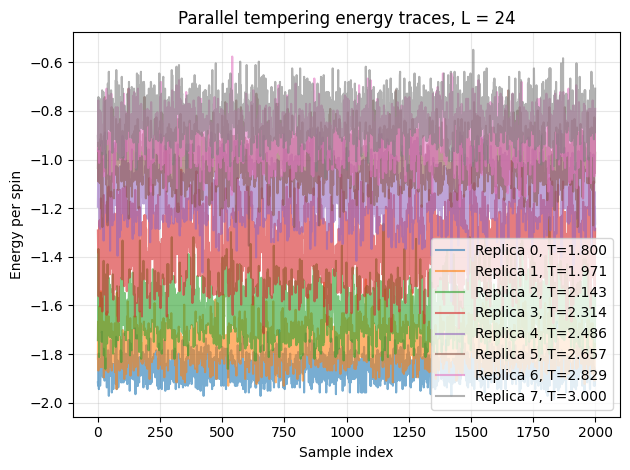

In [23]:
# ---- Cell 11: run parallel tempering only (L = 24, T in [1.8, 3.0]) ----

def run_parallel_tempering_mode() -> Tuple[np.ndarray, np.ndarray]:
    """Run the parallel tempering extension with fixed parameters.

    Uses:
        - L = 24
        - num_replicas = 8
        - T in [1.8, 3.0]
        - sweeps = 120000
        - burn-in = 20000
        - sample_interval = 50
        - swap_interval = 10
        - seed = 123

    Args:
        None

    Returns:
        Tuple[np.ndarray, np.ndarray]: Temperatures and energy samples per replica.
    """
    config = PTConfig(
        lattice_size=24,
        num_replicas=8,
        temperature_min=1.8,
        temperature_max=3.0,
        num_sweeps=120000,
        burn_in_sweeps=20000,
        sample_interval=50,
        swap_interval=10,
        random_seed=123,
    )
    return run_parallel_tempering(config)



temps_pt, energies_pt = run_parallel_tempering_mode()


Parallel tempering summary: replicas = 8, sweeps = 120000, samples = 2000
Total swap attempts = 84000, accepted = 23579, acceptance rate = 0.281


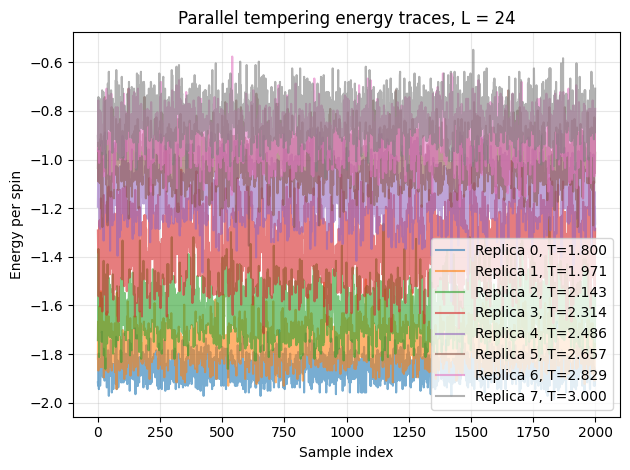

Temperature T = 2.486, lattice size L = 24
Parallel tempering:
  mean(E) = -1.12400, var(E) = 1.04596e-02, tau_int = 0.53, N_eff = 1873.0, SE = 2.36315e-03
Metropolis only:
  mean(E) = -1.12527, var(E) = 9.96778e-03, tau_int = 0.56, N_eff = 1783.6, SE = 2.36400e-03
Variance ratio of mean estimators (Metropolis / PT) ~= 1.00


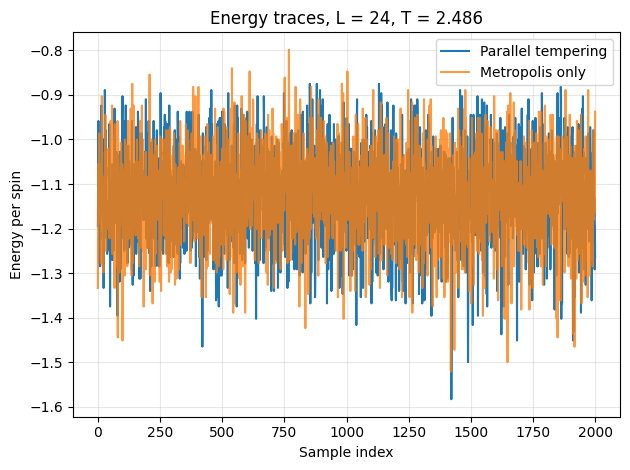

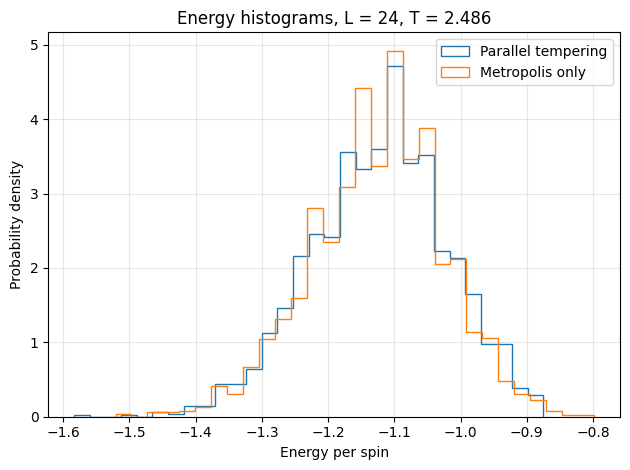

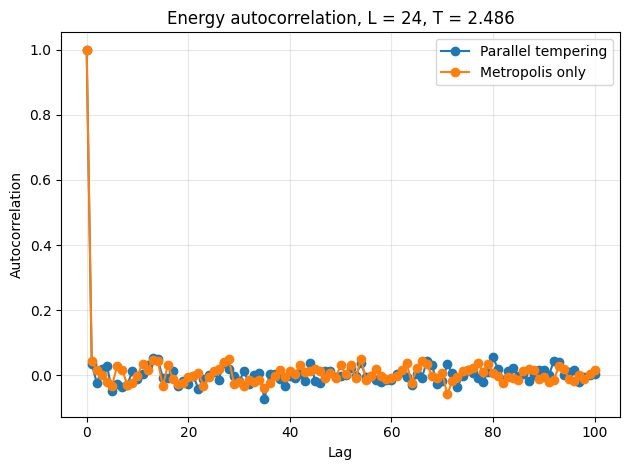

In [24]:
# ---- Cell 12: PT vs Metropolis comparison (L = 24, T ~ 2.486) ----

def run_pt_vs_metropolis_comparison() -> None:
    """Compare parallel tempering and Metropolis at T near the critical point.

    Runs:
        - Parallel tempering with fixed configuration.
        - Single-chain Metropolis at T close to 2.486.
        - Computes statistics and shows trace, histogram and ACF plots.

    Args:
        None

    Returns:
        None
    """
    pt_config = PTConfig(
        lattice_size=24,
        num_replicas=8,
        temperature_min=1.8,
        temperature_max=3.0,
        num_sweeps=120000,
        burn_in_sweeps=20000,
        sample_interval=50,
        swap_interval=10,
        random_seed=123,
    )

    temperatures, energies_samples = run_parallel_tempering(pt_config)
    num_samples, _ = energies_samples.shape
    l = pt_config.lattice_size

    t_target = 2.486
    idx_target = int(np.argmin(np.abs(temperatures - t_target)))
    t_pt = float(temperatures[idx_target])
    e_pt_series = energies_samples[:, idx_target]

    rng = make_rng(seed=999)
    beta = 1.0 / t_pt
    spins = ising2d_initial_state(lattice_size=l, rng=rng)

    num_sweeps_total = pt_config.num_sweeps
    burn_in = pt_config.burn_in_sweeps
    sample_interval = pt_config.sample_interval

    e_met_series_list: List[float] = []

    for _ in range(burn_in):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    for sweep in range(num_sweeps_total - burn_in):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            e, _ = measure_observables_2d(spins, beta)
            e_met_series_list.append(e)

    e_met_series = np.array(e_met_series_list, dtype=float)

    num_samples_pt = e_pt_series.size
    num_samples_met = e_met_series.size
    if num_samples_met != num_samples_pt:
        n_common = min(num_samples_pt, num_samples_met)
        e_pt_series = e_pt_series[:n_common]
        e_met_series = e_met_series[:n_common]

    def compute_stats(x: np.ndarray) -> Tuple[float, float, float, float, float]:
        """Compute basic Monte Carlo statistics for an observable time series.

        Args:
            x (np.ndarray): Time series of observable values.

        Returns:
            Tuple[float, float, float, float, float]: Mean, variance, integrated
                autocorrelation time, effective sample size and standard error.
        """
        mean_e = float(np.mean(x))
        var_e = float(np.var(x, ddof=1))
        max_lag = max(1, len(x) // 10)
        tau_int = integrated_autocorrelation_time(x, max_lag=max_lag)
        n_eff = len(x) / (2.0 * tau_int)
        se = math.sqrt(var_e / n_eff)
        return mean_e, var_e, tau_int, n_eff, se

    mean_pt, var_pt, tau_pt, n_eff_pt, se_pt = compute_stats(e_pt_series)
    mean_met, var_met, tau_met, n_eff_met, se_met = compute_stats(e_met_series)

    print(f"Temperature T = {t_pt:.3f}, lattice size L = {l}")
    print("Parallel tempering:")
    print(
        f"  mean(E) = {mean_pt:.5f}, var(E) = {var_pt:.5e}, "
        f"tau_int = {tau_pt:.2f}, N_eff = {n_eff_pt:.1f}, "
        f"SE = {se_pt:.5e}"
    )
    print("Metropolis only:")
    print(
        f"  mean(E) = {mean_met:.5f}, var(E) = {var_met:.5e}, "
        f"tau_int = {tau_met:.2f}, N_eff = {n_eff_met:.1f}, "
        f"SE = {se_met:.5e}"
    )

    var_mean_pt = var_pt / n_eff_pt
    var_mean_met = var_met / n_eff_met
    speedup_variance = var_mean_met / var_mean_pt
    print(
        "Variance ratio of mean estimators (Metropolis / PT) "
        f"~= {speedup_variance:.2f}"
    )

    plt.figure()
    plt.plot(e_pt_series, label="Parallel tempering")
    plt.plot(e_met_series, label="Metropolis only", alpha=0.8)
    plt.xlabel("Sample index")
    plt.ylabel("Energy per spin")
    plt.title(f"Energy traces, L = {l}, T = {t_pt:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(
        e_pt_series,
        bins=30,
        density=True,
        histtype="step",
        label="Parallel tempering",
    )
    plt.hist(
        e_met_series,
        bins=30,
        density=True,
        histtype="step",
        label="Metropolis only",
    )
    plt.xlabel("Energy per spin")
    plt.ylabel("Probability density")
    plt.title(f"Energy histograms, L = {l}, T = {t_pt:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    max_lag_plot = max(50, len(e_pt_series) // 20)
    acf_pt = autocorrelation(e_pt_series, max_lag=max_lag_plot)
    acf_met = autocorrelation(e_met_series, max_lag=max_lag_plot)

    lags = np.arange(max_lag_plot + 1)
    plt.figure()
    plt.plot(lags, acf_pt, "o-", label="Parallel tempering")
    plt.plot(lags, acf_met, "o-", label="Metropolis only")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"Energy autocorrelation, L = {l}, T = {t_pt:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



run_pt_vs_metropolis_comparison()
